# Demand forecasting with the Temporal Fusion Transformer


In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
path = os.getcwd() + '/docs/source/tutorials/project_data/'

## Load data


In [76]:
# data = pd.read_csv(path + 'MiningProcess_Flotation_Plant_Database.csv', decimal=',', parse_dates=['date'],
#     infer_datetime_format=True)

# data["time_idx"] = data["date"].dt.month * 31 + data["date"].dt.day
# data["time_idx"] -= data["time_idx"].min()
# data['hour'] = data["date"].dt.hour
#data.groupby(['time_idx', 'hour']).mean().reset_index().to_csv(path+'flotation_hourly.csv')

In [85]:
data = pd.read_csv(path+'continuous_factory_process.csv', index_col=0)
data = data.reset_index()
data['time_stamp'] = pd.to_datetime(data['time_stamp']) 
time = data['time_stamp'].dt.strftime('%H:%M:%S')
data = data.drop(['time_stamp'], axis =1)
data = pd.concat([time, data], axis= 1)
#data = data.drop(['time_stamp'], axis=1)
data

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
1,10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
2,10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
3,10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
4,10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,...,7.87,7.93,5.53,5.65,2.07,1.85,3.80,2.89,7.56,11.71
14084,14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,...,7.85,7.93,5.48,5.65,2.01,1.85,3.79,2.89,7.76,11.71
14085,14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,...,7.93,7.93,5.54,5.65,2.06,1.85,3.83,2.89,7.66,11.71
14086,14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,...,7.85,7.93,5.51,5.65,2.05,1.85,3.83,2.89,7.87,11.71


In [87]:
data_1 = data.iloc[:, :72]
data_1

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint
0,10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,...,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72
1,10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
2,10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
3,10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
4,10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,...,7.54,8.65,5.15,6.16,1.15,2.02,2.72,3.16,0.00,17.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14084,14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14085,14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14086,14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,...,7.66,8.65,0.00,6.16,1.40,2.02,3.30,3.16,0.00,17.72


In [88]:
a = list(data.columns)
data_2 = data[a[:3]+a[43:]]
data_2

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Stage1.Output.Measurement0.U.Setpoint,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement1.U.Setpoint,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,10:52:33,17.24,23.53,13.75,0.0,22.74,12.16,13.02,21.97,21.88,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
1,10:52:34,17.24,23.53,13.75,0.0,22.74,0.00,13.02,17.78,21.88,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
2,10:52:35,17.24,23.53,13.75,0.0,22.74,0.00,13.02,17.78,21.88,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
3,10:52:36,17.24,23.53,13.75,0.0,22.74,0.00,13.02,17.78,21.88,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
4,10:52:37,17.24,23.53,13.75,0.0,22.74,0.00,13.02,17.83,21.88,...,0.00,7.93,0.00,5.65,0.00,1.85,0.00,2.89,0.00,11.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,14:47:16,13.84,24.43,13.75,0.0,22.74,9.14,13.02,21.50,21.88,...,7.87,7.93,5.53,5.65,2.07,1.85,3.80,2.89,7.56,11.71
14084,14:47:17,13.84,24.43,13.75,0.0,22.74,9.14,13.02,21.50,21.88,...,7.85,7.93,5.48,5.65,2.01,1.85,3.79,2.89,7.76,11.71
14085,14:47:18,13.84,24.43,13.75,0.0,22.74,9.14,13.02,21.50,21.88,...,7.93,7.93,5.54,5.65,2.06,1.85,3.83,2.89,7.66,11.71
14086,14:47:19,13.84,24.43,13.75,0.0,22.74,8.99,13.02,21.84,21.88,...,7.85,7.93,5.51,5.65,2.05,1.85,3.83,2.89,7.87,11.71


In [84]:
# from pytorch_forecasting.data.examples import get_stallion_data
# data = get_stallion_data()

# # add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()

#add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [81]:
data.describe()

,time_idx,hour,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,...,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000
mean,98.852819,11.507200,56.294730,14.651733,2869.142009,488.145318,397.578386,9.767642,1.680380,280.151579,...,290.754471,520.244362,522.649044,531.352098,420.321254,425.251991,429.941327,421.021513,65.050084,2.326754
std,50.868522,6.925349,5.158347,6.808236,950.480080,83.689937,8.370683,0.378027,0.063775,29.410048,...,27.219983,122.175617,116.054997,138.588088,76.585553,75.033153,75.507250,72.555295,1.118099,1.124783
min,0.000000,0.000000,42.740000,1.310000,54.595483,242.927477,376.837604,8.753389,1.519926,175.885579,...,199.728122,181.925623,224.909663,135.214506,165.725058,214.735894,203.702926,185.061388,62.050000,0.600000
25%,56.000000,5.000000,52.670000,8.940000,2168.968993,436.037967,398.851356,9.540878,1.651352,250.089767,...,283.155469,416.468100,449.249644,405.366394,351.490017,350.979578,354.128200,350.939278,64.370000,1.440000
50%,99.000000,12.000000,56.080000,13.850000,2908.340847,502.454283,399.842656,9.795850,1.695705,299.837839,...,299.861167,499.619556,499.822467,499.593706,401.272994,401.127639,407.549394,400.988261,65.210000,2.000000
75%,143.000000,18.000000,59.720000,19.600000,3528.727412,549.522256,400.589883,10.030779,1.721790,299.951350,...,300.112433,599.712939,599.331622,600.215106,496.201878,497.775572,497.806211,462.283886,65.860000,3.010000
max,185.000000,23.000000,65.780000,33.400000,6270.158798,736.982378,418.070232,10.807370,1.832430,312.295415,...,351.268656,859.025062,827.775874,884.840698,675.631942,674.068176,698.505832,655.501603,68.010000,5.530000


### Create dataset and dataloaders


In [82]:
data.columns

Index(['time_idx', 'hour', '% Iron Feed', '% Silica Feed', 'Starch Flow',
       'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [9]:
max_prediction_length = 12
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="% Silica Concentrate",
    #group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create baseline model


In [10]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(baseline_predictions.output, baseline_predictions.y)

2023-06-05 13:24:06.795157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 13:24:07.667115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensor(293.0088)

## Train the Temporal Fusion Transformer


### Find optimal learning rate


Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).


In [11]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.041686938347033554
Restoring states from the checkpoint path at /home/slcf/project/pytorch-forecasting/.lr_find_410a5587-3db4-4d22-ab45-39ff2ce72d47.ckpt
Restored all states from the checkpoint at /home/slcf/project/pytorch-forecasting/.lr_find_410a5587-3db4-4d22-ab45-39ff2ce72d47.ckpt


suggested learning rate: 0.041686938347033554


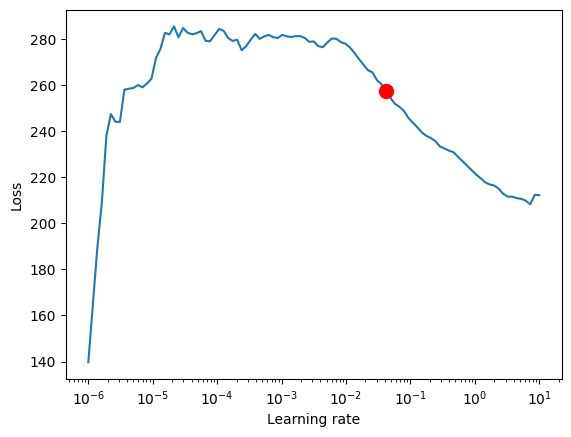

In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model


If you have troubles training the model and get an error `AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'`, consider either uninstalling tensorflow or first execute

````
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.
````


In [13]:
import tensorflow as tf
import tensorboard as tb

In [14]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.


In [15]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Hyperparameter tuning


## Evaluate performance


PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.


In [16]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(245.3896)

In [18]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

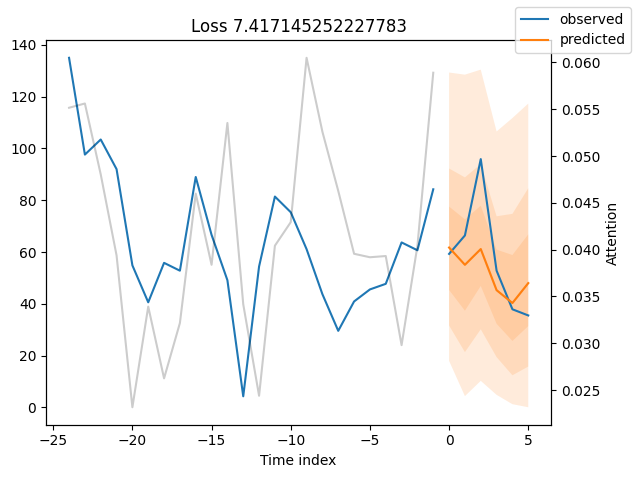

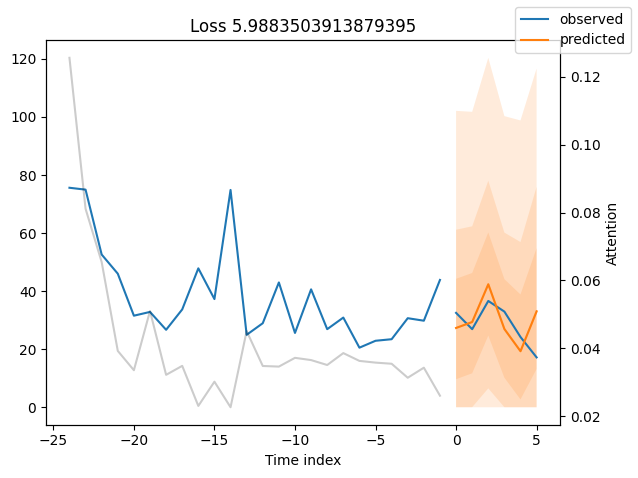

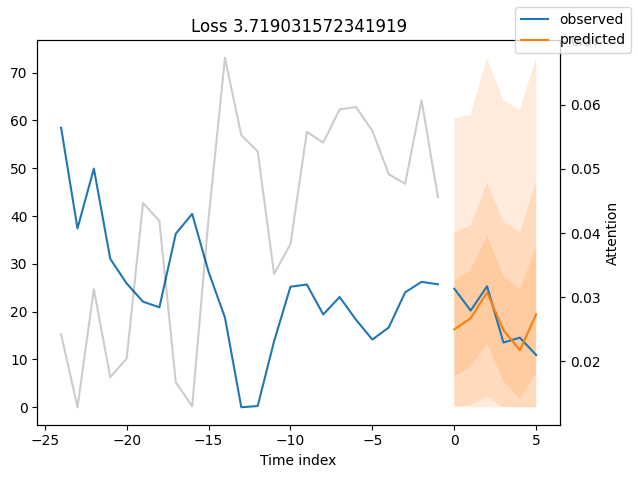

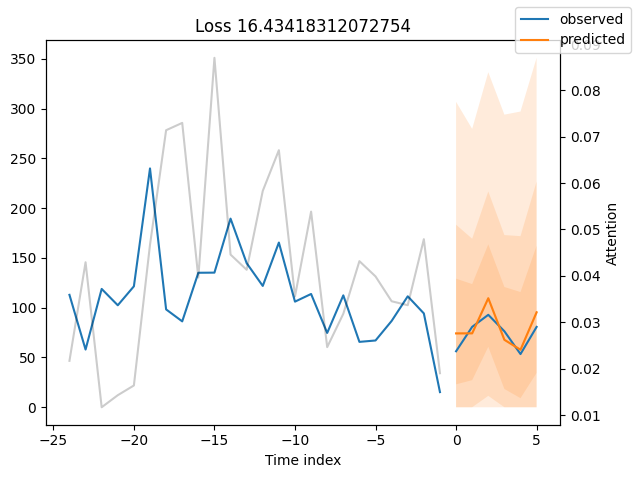

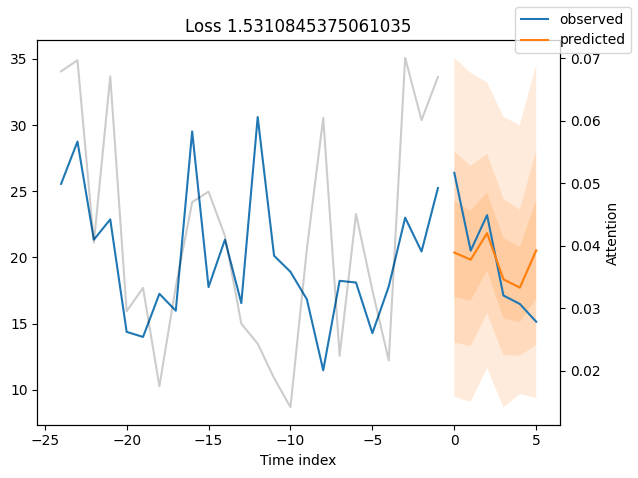

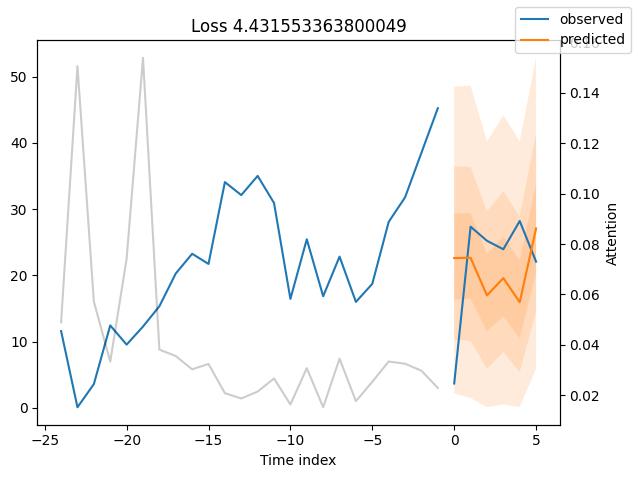

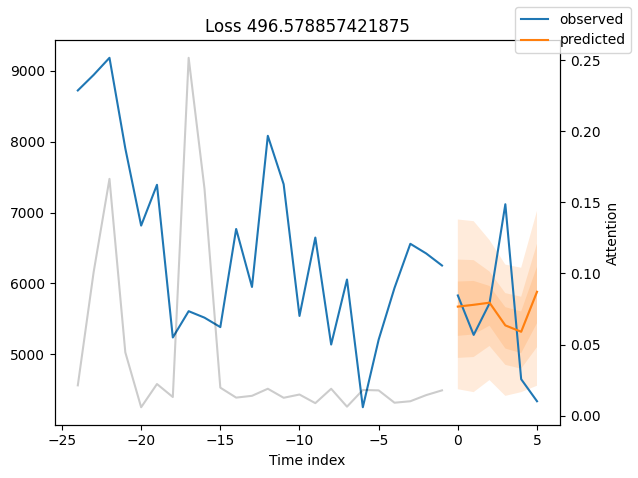

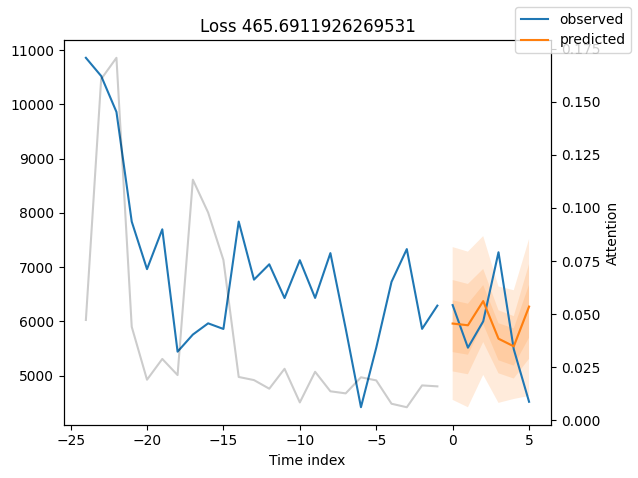

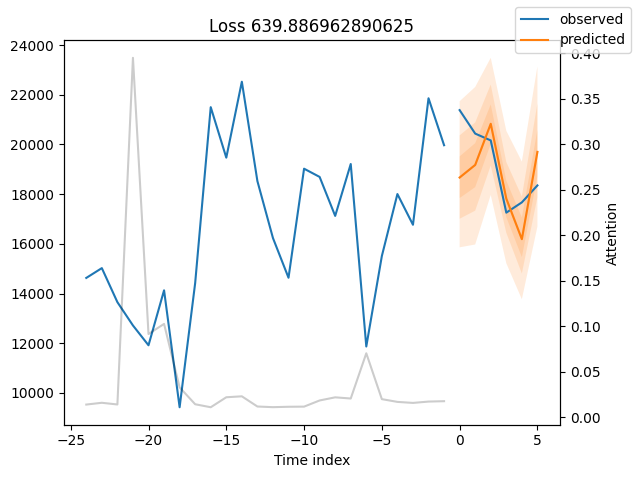

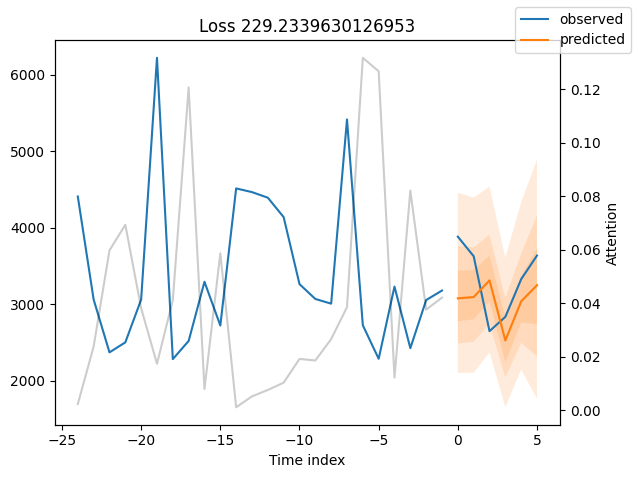

In [19]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

### Worst performers


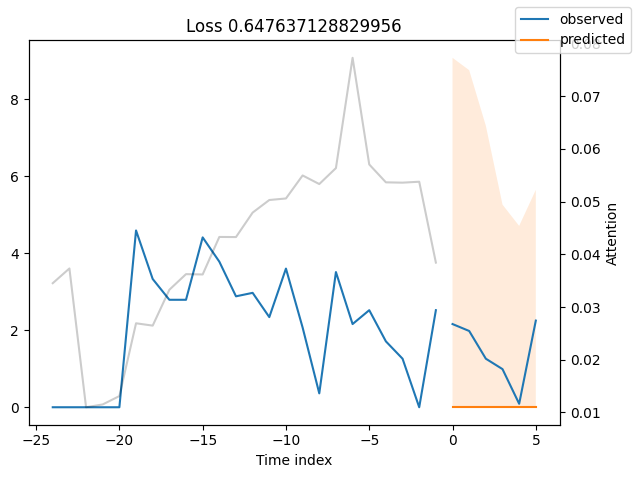

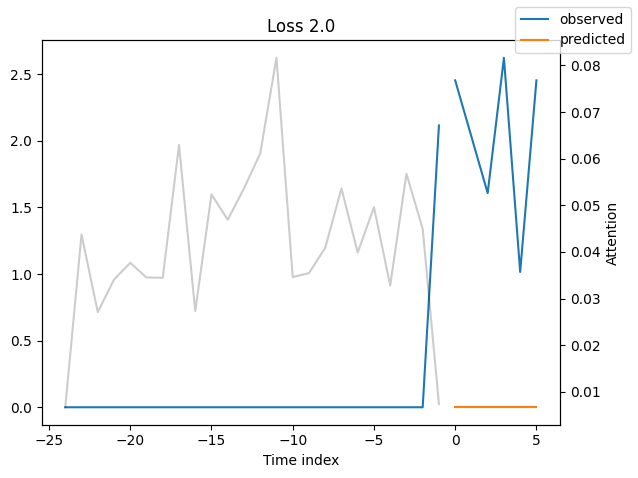

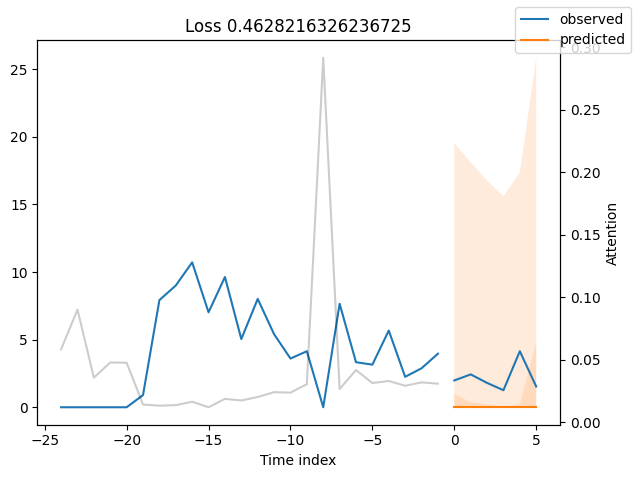

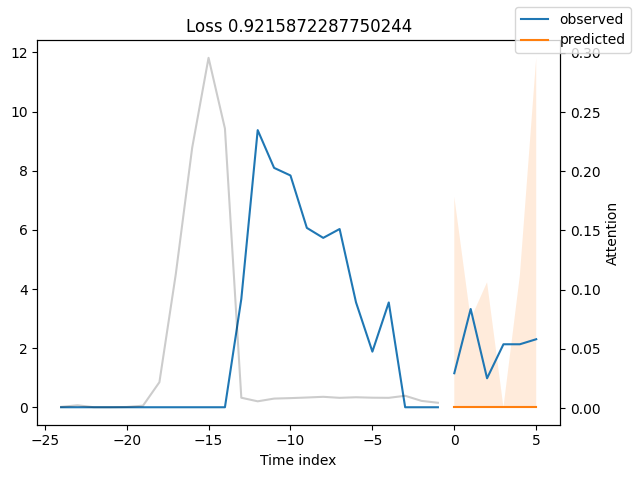

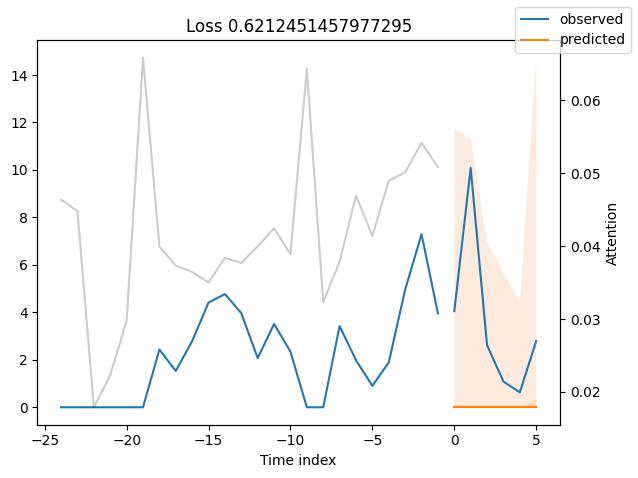

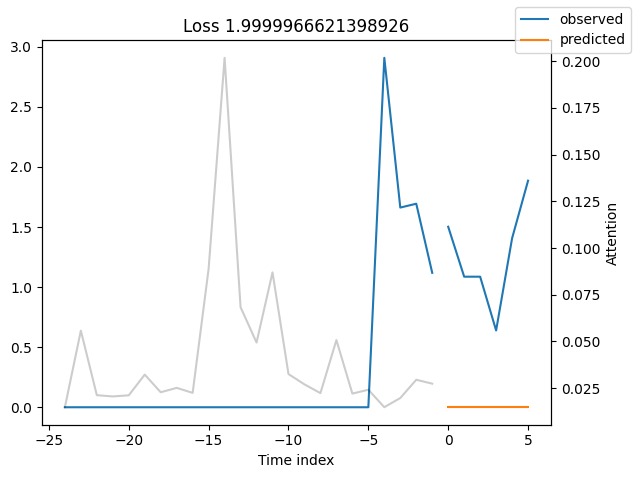

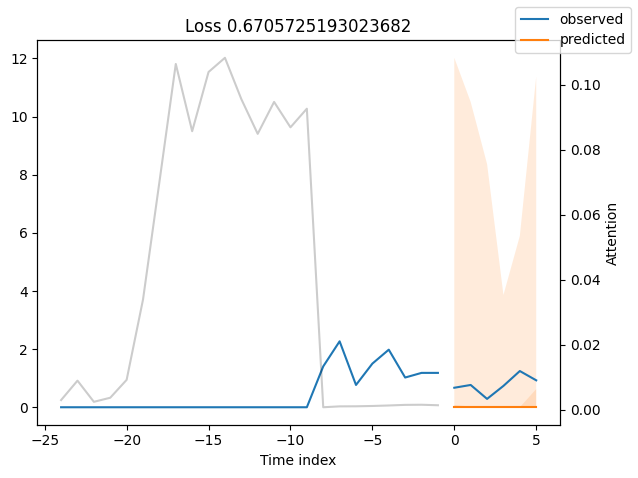

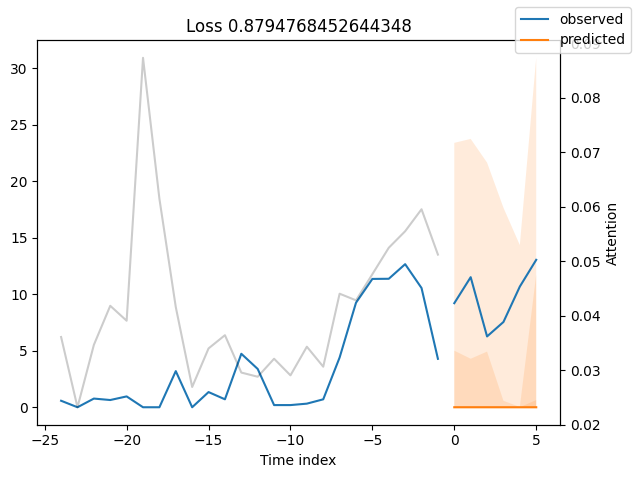

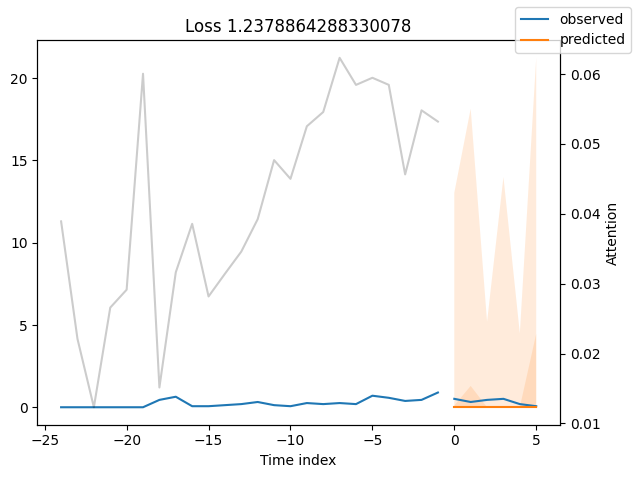

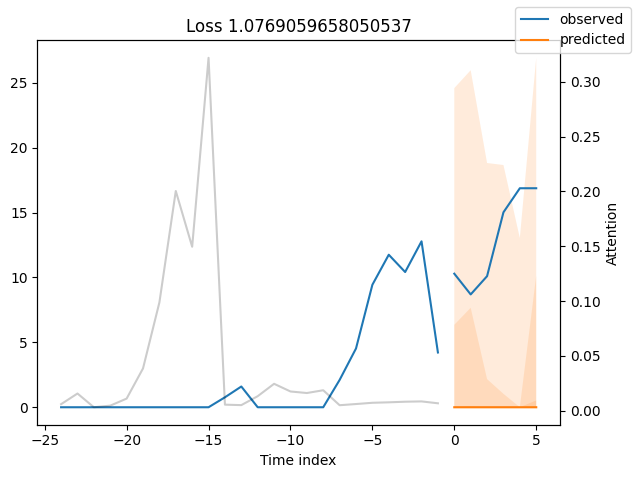

In [20]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

### Actuals vs predictions by variables


{'avg_population_2017': <Figure size 1000x500 with 2 Axes>,
 'avg_yearly_household_income_2017': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'volume_center': <Figure size 1000x500 with 2 Axes>,
 'volume_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'price_regular': <Figure size 1000x500 with 2 Axes>,
 'discount_in_percent': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'log_volume': <Figure size 1000x500 with 2 Axes>,
 'industry_volume': <Figure size 1000x500 with 2 Axes>,
 'soda_volume': <Figure size 1000x500 with 2 Axes>,
 'avg_max_temp': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_agency': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_sku': <Figure size 1000x500 with 2 Axes>,
 'agency': <Figure size 1000x500 with 2 Axes>,
 'sku': <Figure size 1000x500 with 2 Axes>,
 'special_days'

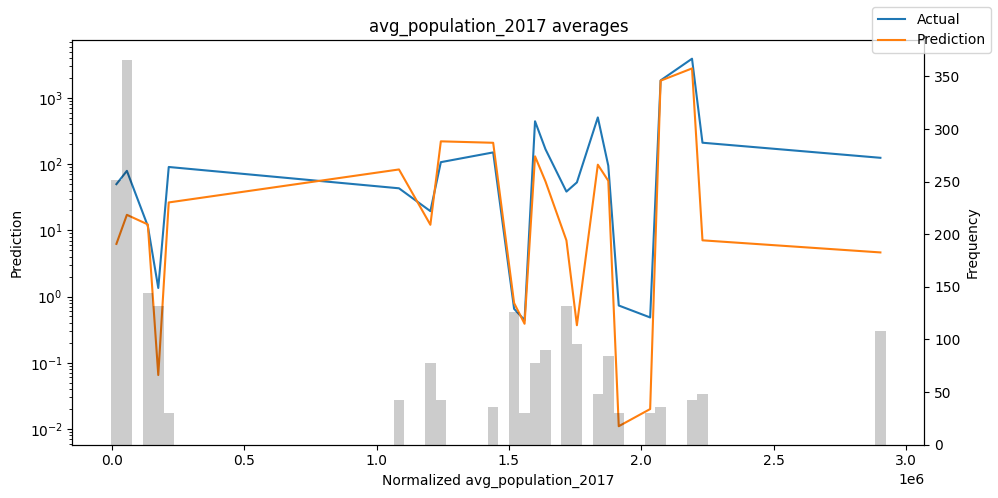

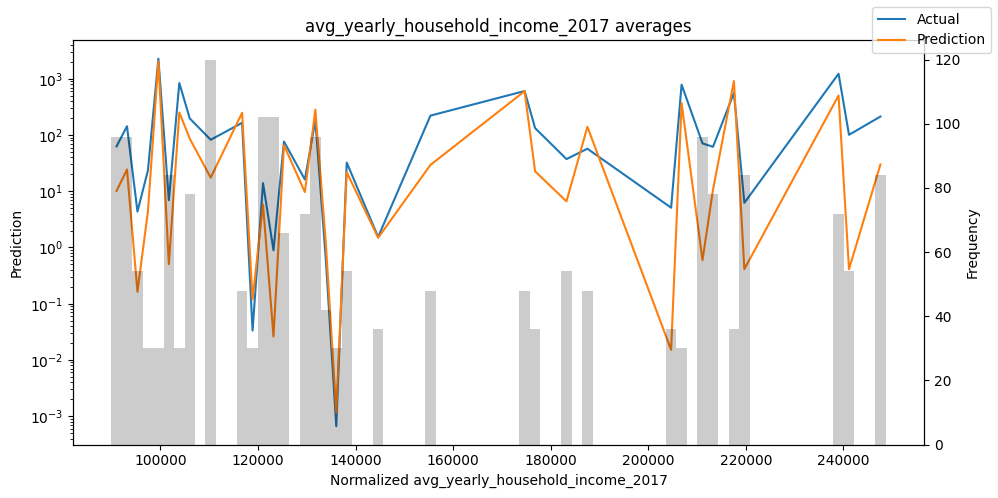

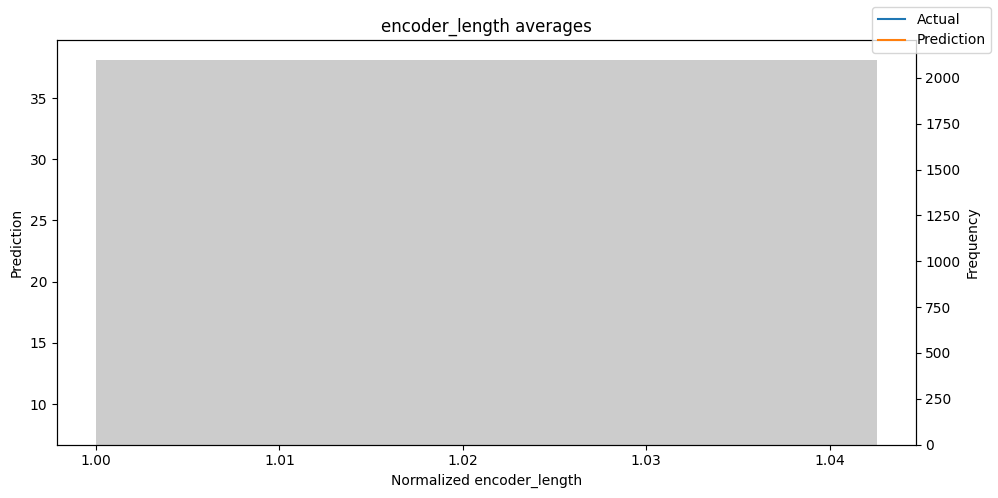

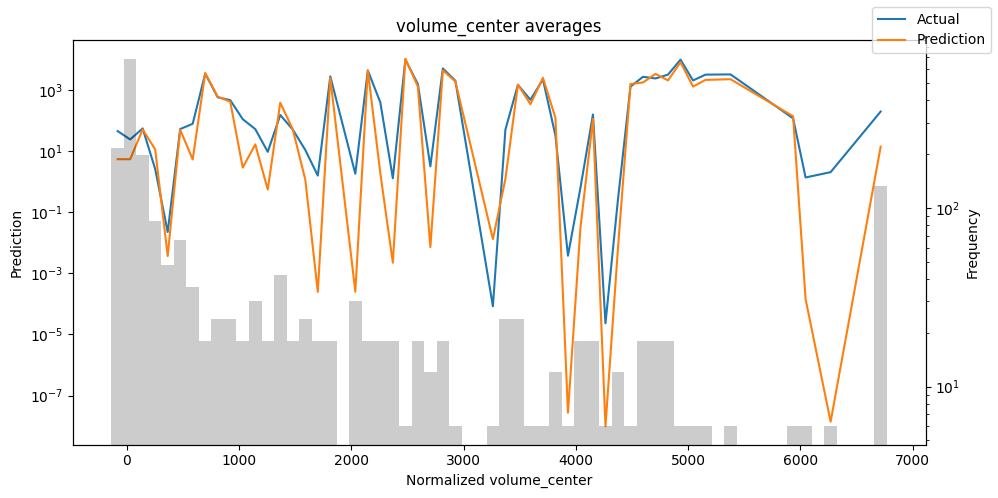

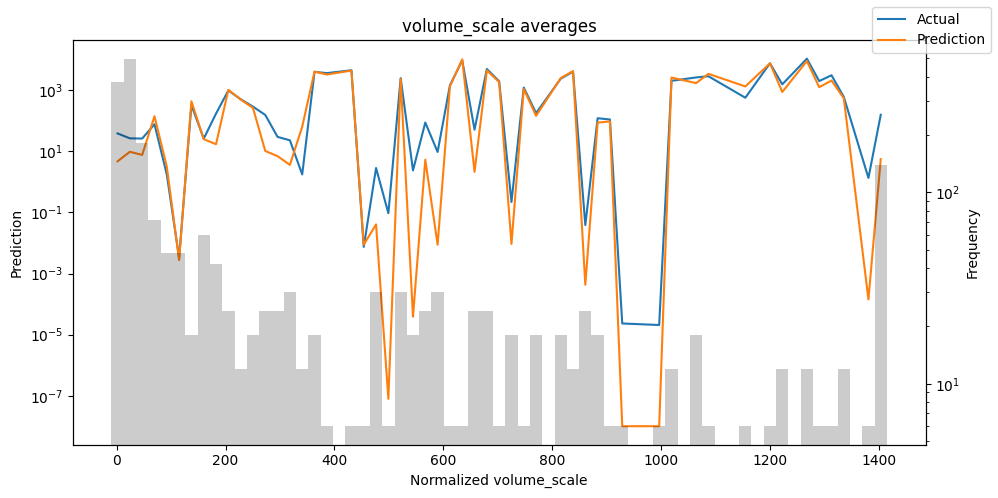

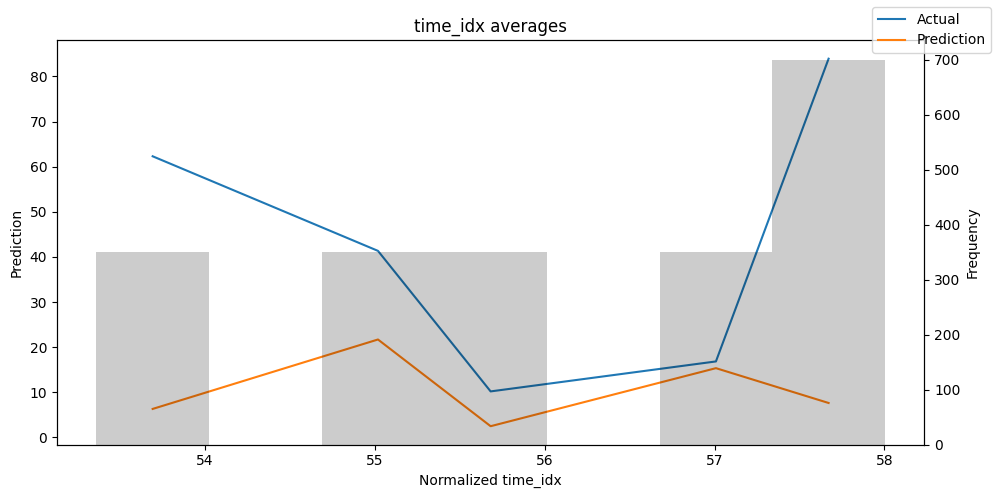

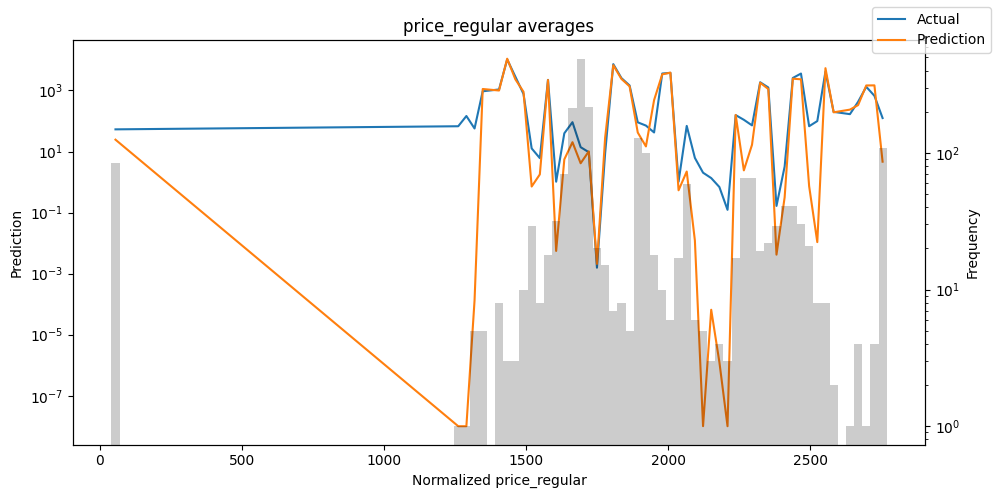

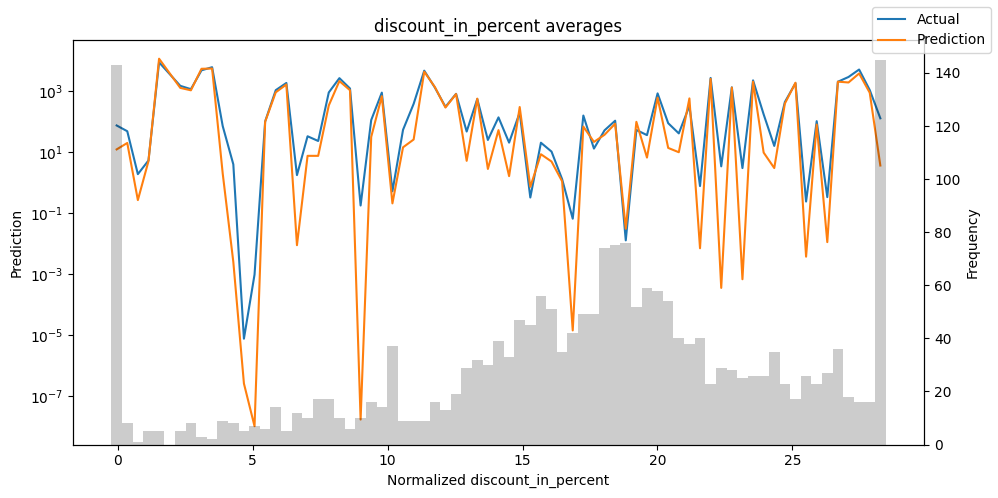

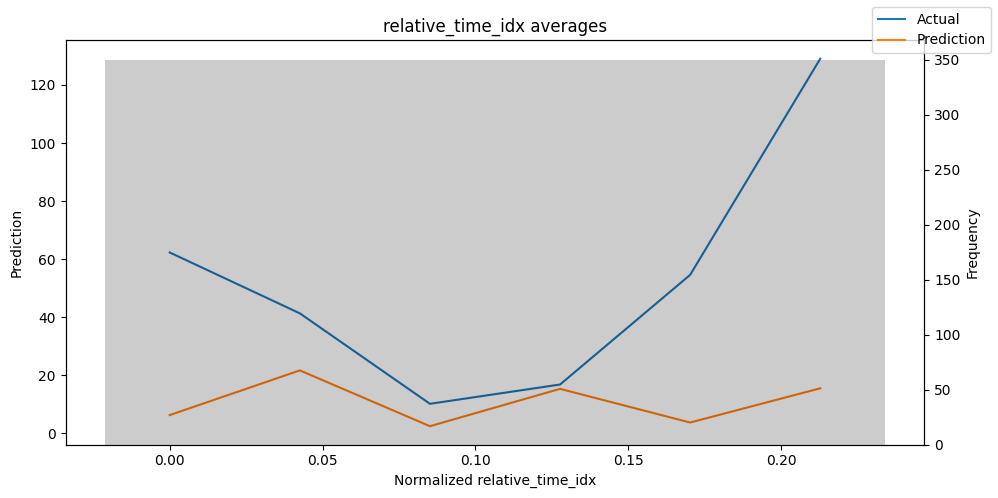

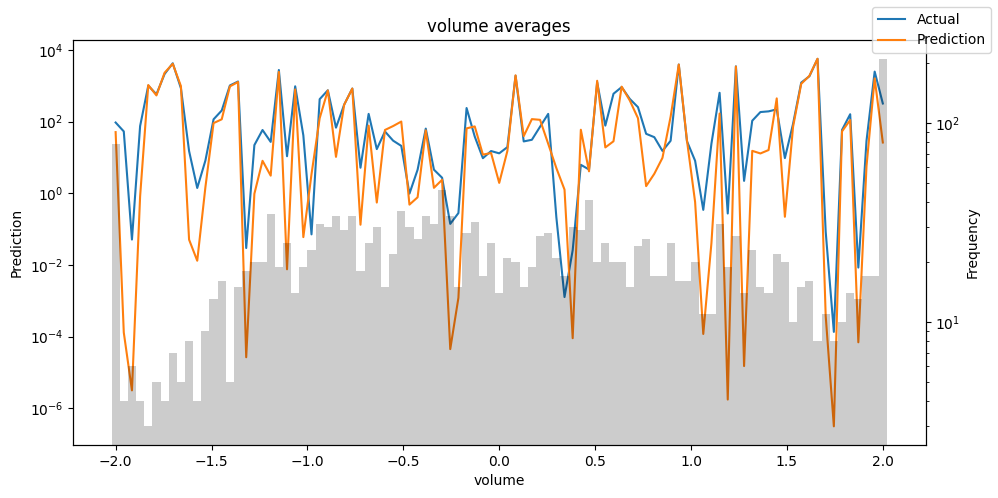

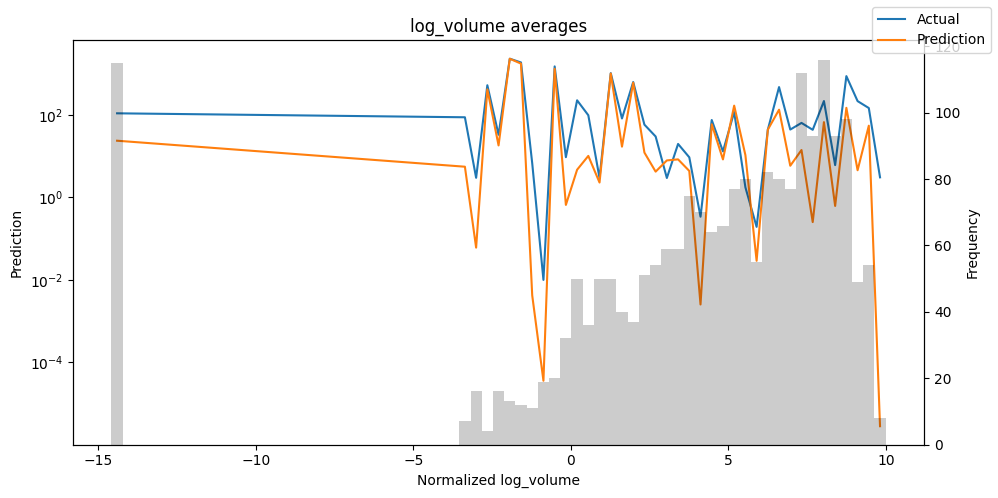

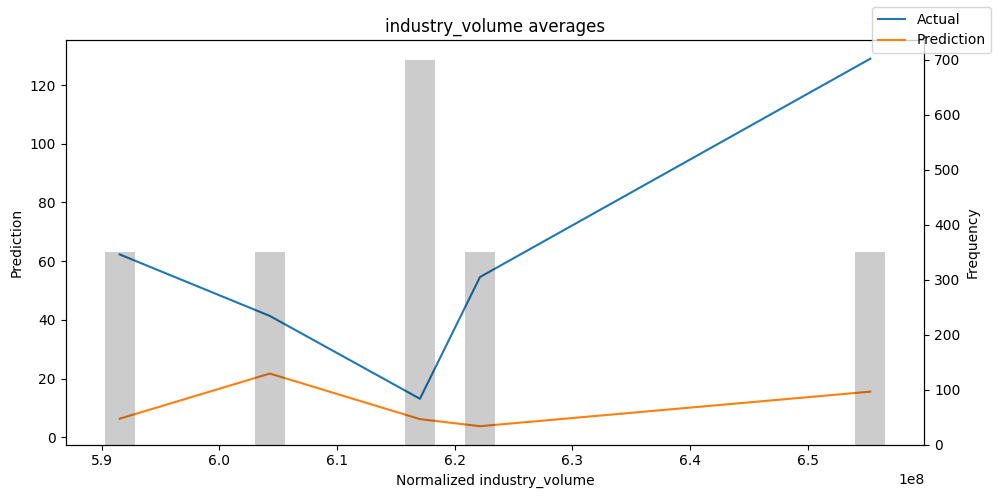

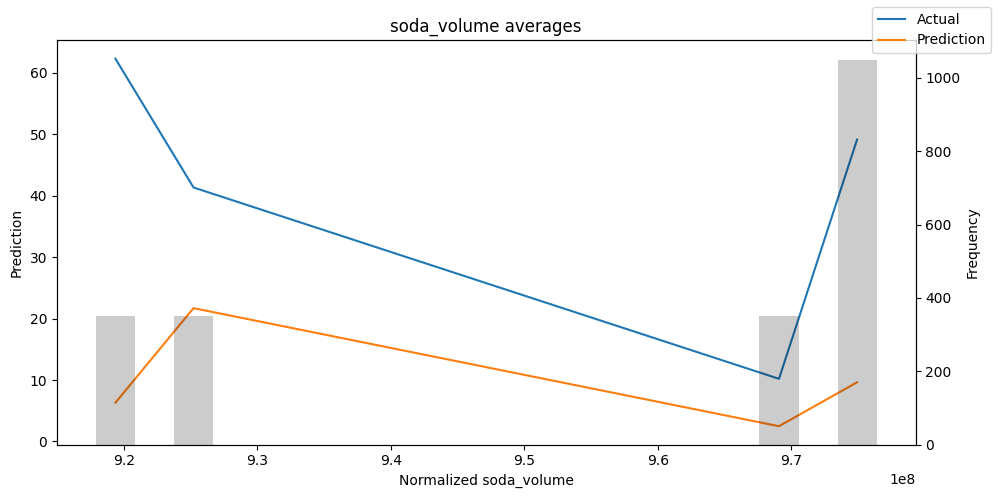

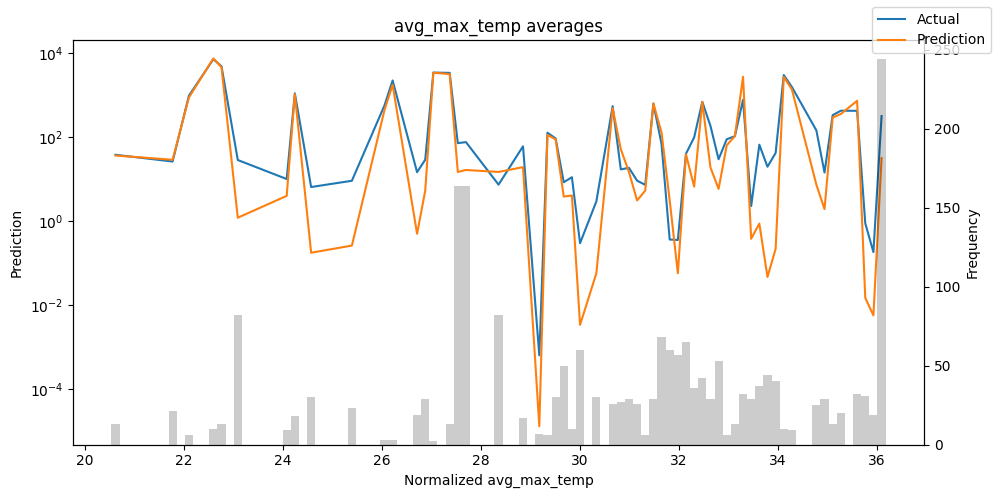

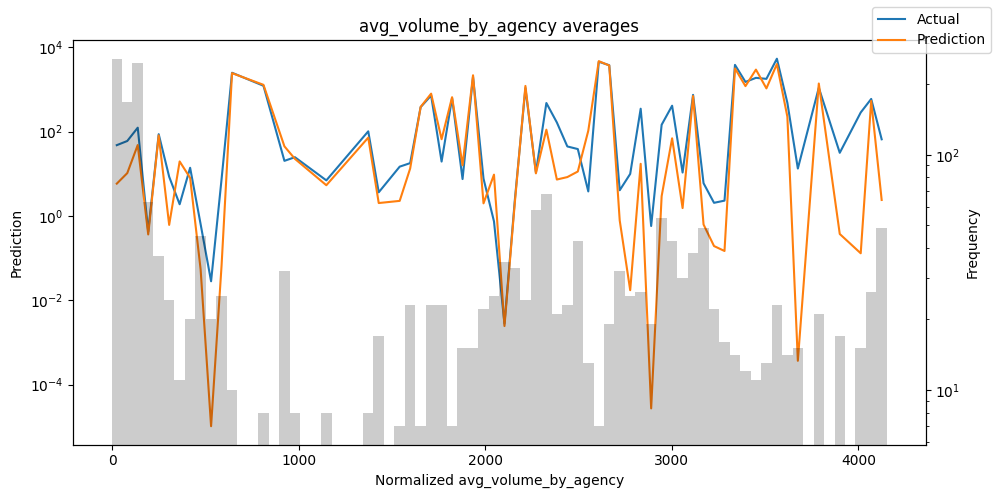

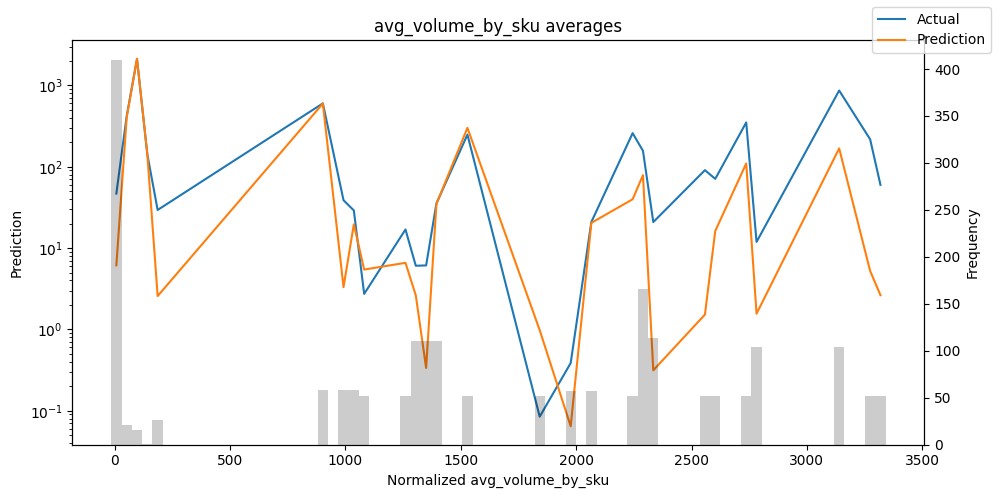

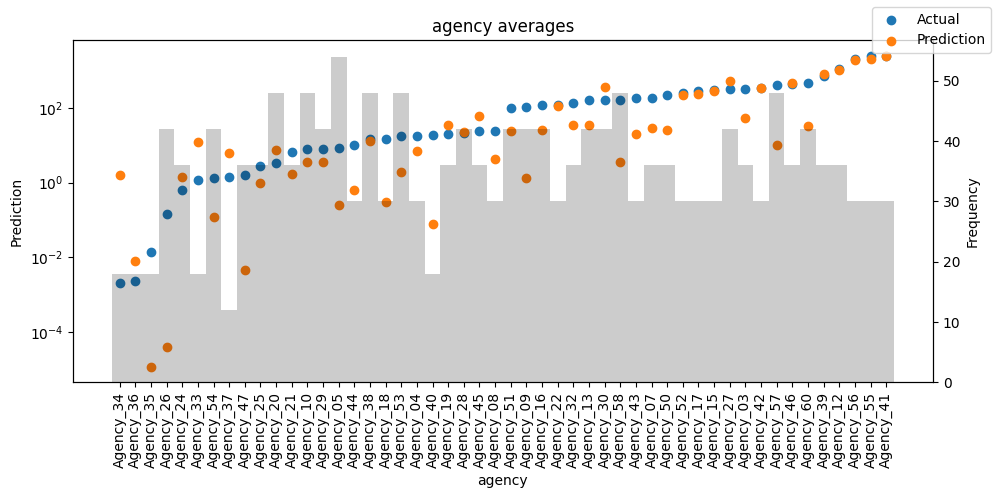

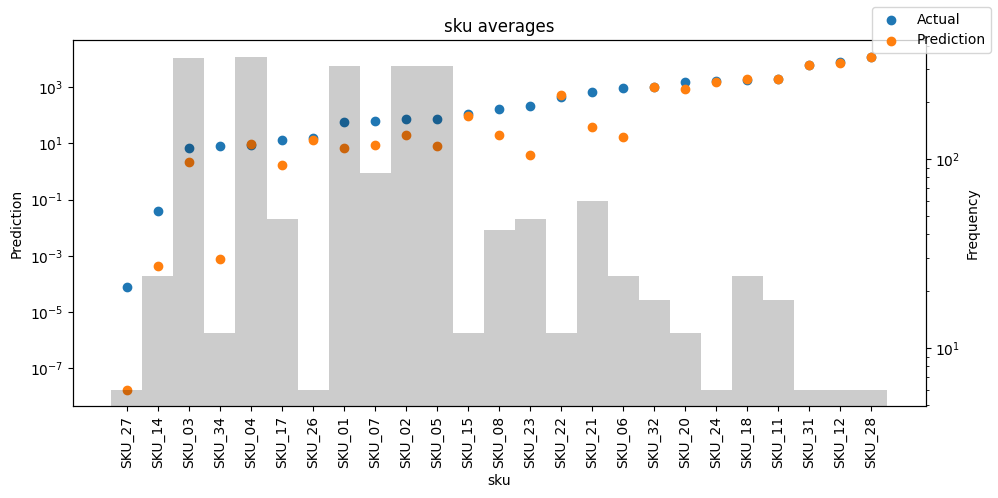

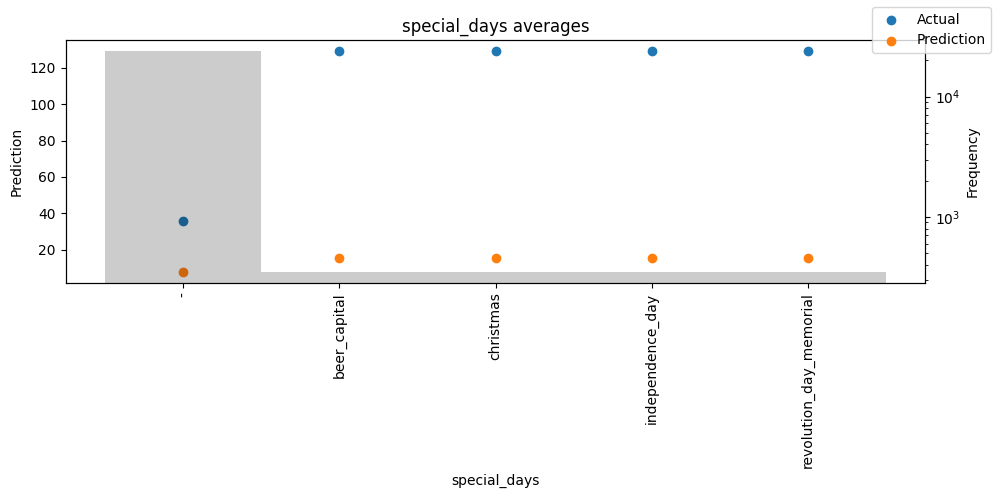

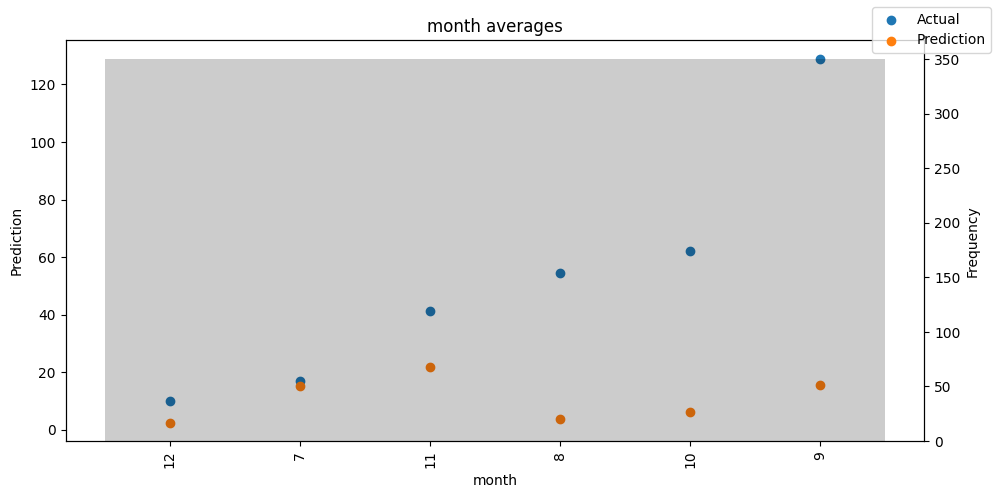

In [21]:
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Predict on selected data


In [23]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles", trainer_kwargs=dict(accelerator="cpu")
)

tensor([[[ 79.5879, 106.5963, 127.0679, 146.3964, 165.7474, 184.8991, 208.7635],
         [ 51.1931,  84.4729, 106.2249, 125.0061, 145.5975, 166.3181, 196.4315],
         [ 32.3981,  59.6265,  77.8936,  94.2884, 111.3729, 127.0665, 152.1406],
         [ 34.2262,  59.6808,  76.8642,  93.4516, 111.7432, 129.7459, 161.8719],
         [ 35.2198,  62.7229,  80.3172,  95.9842, 113.2462, 129.5772, 161.6644],
         [ 23.5201,  47.8789,  63.6779,  78.0190,  93.5750, 108.4708, 136.7861]]])

Of course, we can also plot this prediction readily:


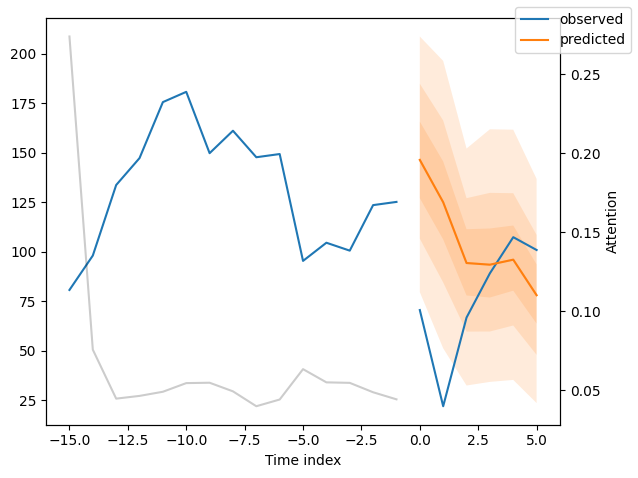

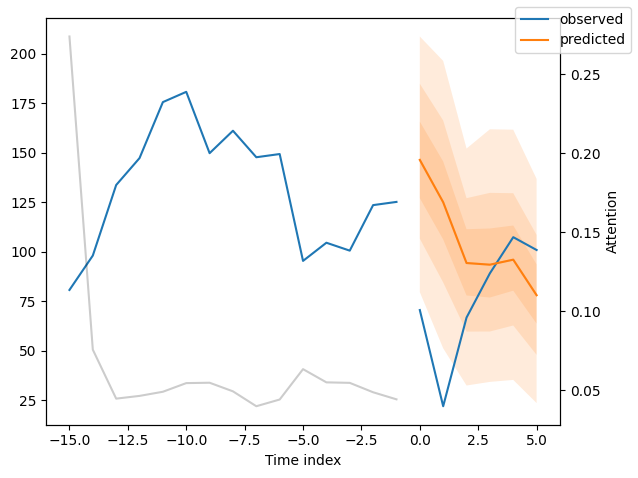

In [24]:
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,trainer_kwargs=dict(accelerator="cpu")
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

## Predict on new data


Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.


In [25]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

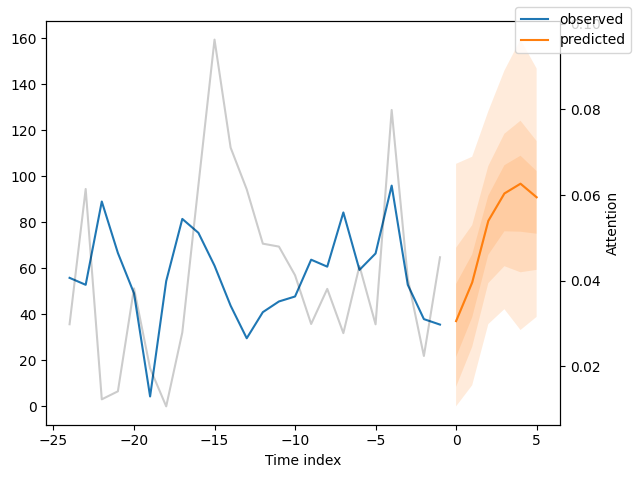

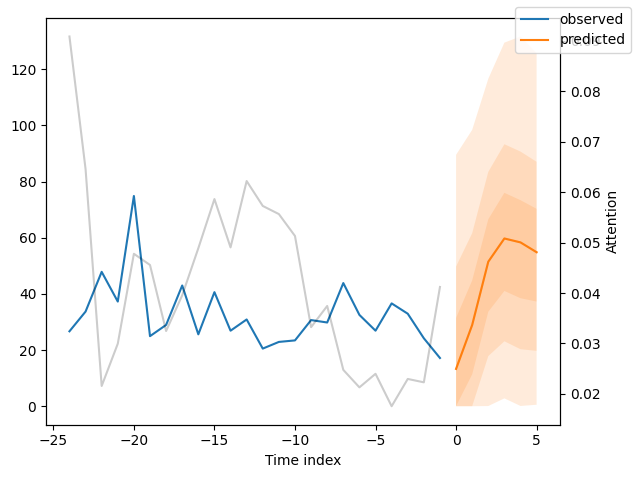

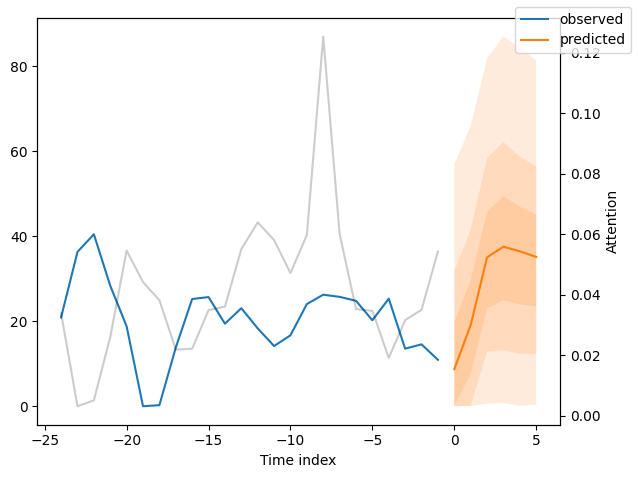

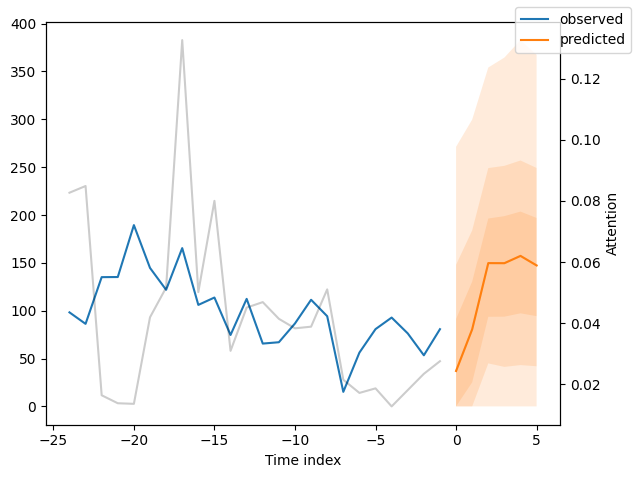

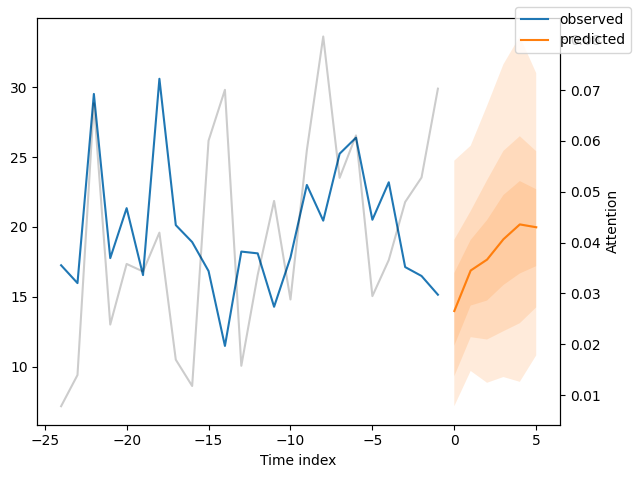

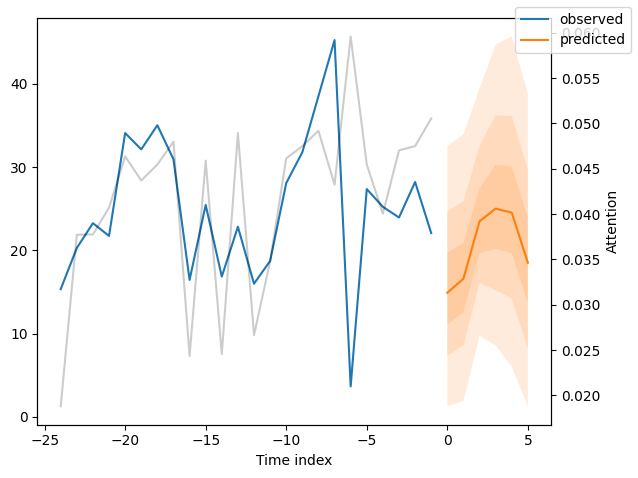

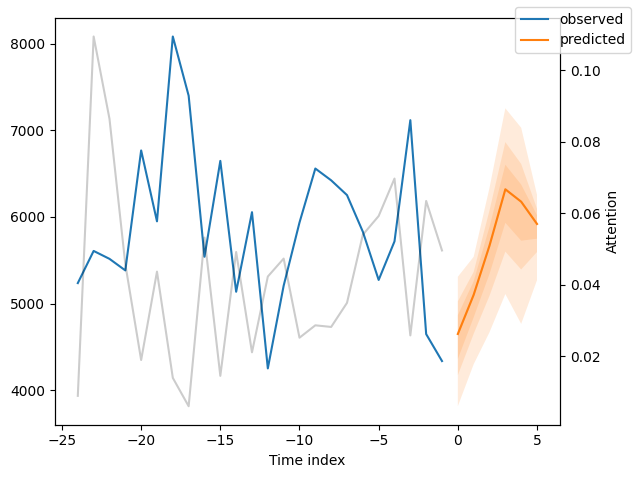

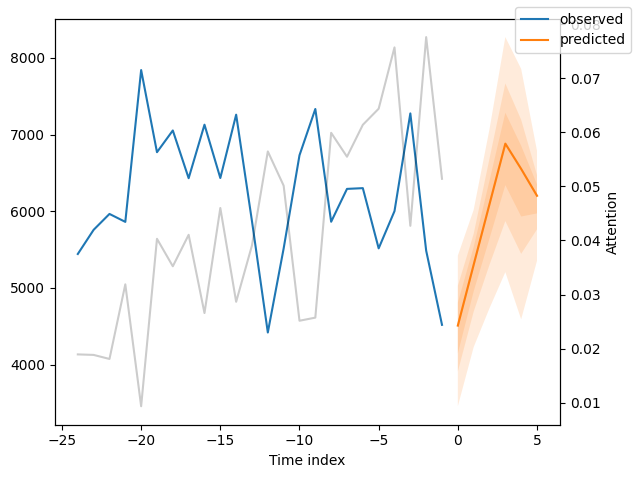

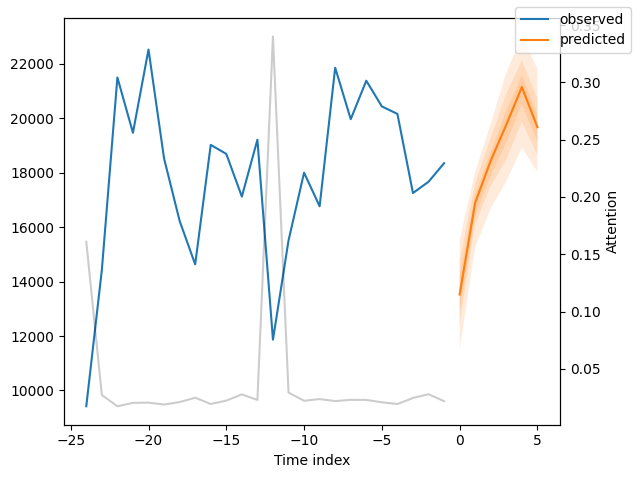

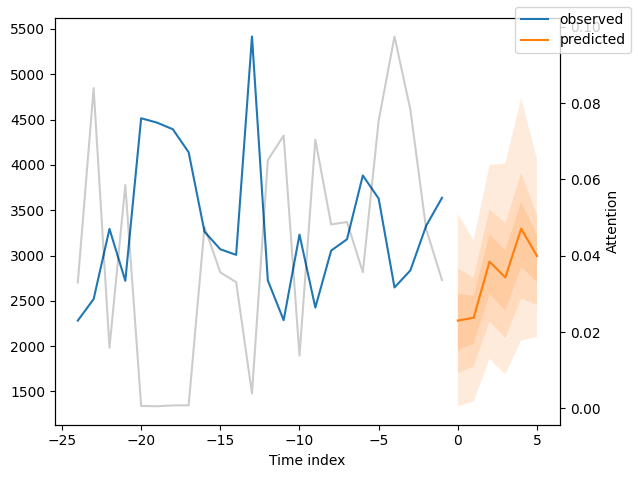

In [27]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=False)

## Interpret model


### Variable importances


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

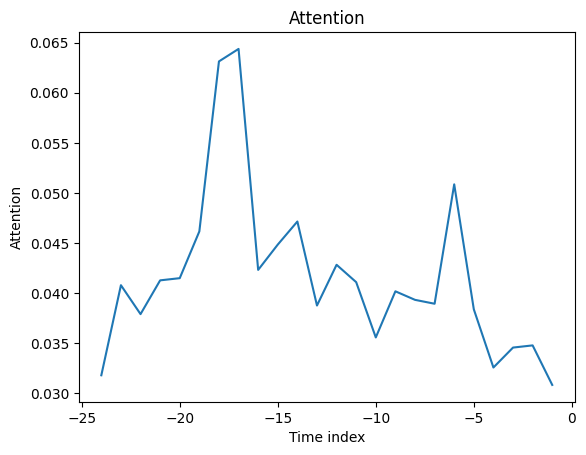

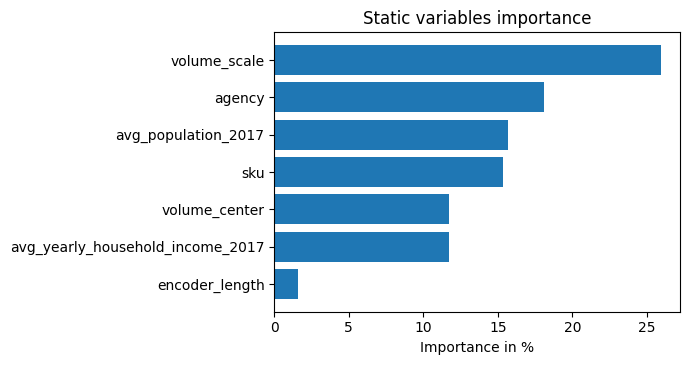

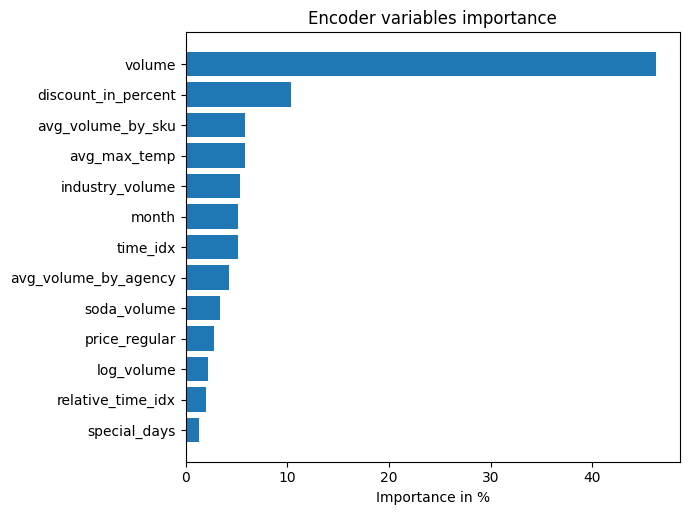

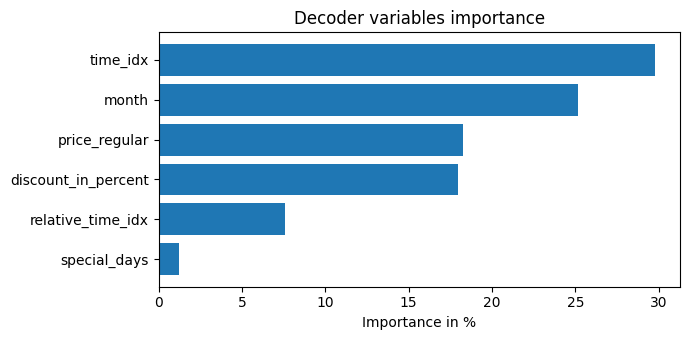

In [28]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.


### Partial dependency
- 왠지모르겠는데 에러남.

In [30]:
# dependency = best_tft.predict_dependency(
#     val_dataloader.datdaset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe")

In [ ]:
# # plotting median and 25% and 75% percentile
# agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
#     median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
# )
# ax = agg_dependency.plot(y="median")
# ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)